<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/doom_reinforce_montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doom: REINFORCE Monte Carlo Policy Gradients 🕹️

In [0]:
!nvidia-smi

Wed Nov 13 03:11:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 1. Build dependencies 🏗️

In [0]:
%%bash
# Based on: 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

# ZDoom dependencies
apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
sudo apt-get install libboost-all-dev

# Python 3 dependencies
sudo apt-get install python3-dev python3-pip

# Lua binding dependencies
apt-get install liblua5.1-dev


Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
libgtk2.0-dev is already the newest version (2.24.32-1ubuntu1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
unzip is already the newest version (6.0-21ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libfluidsynth-dev is already the newest version (1.1.9-1).
libgme-dev is already the newest version (0.6.2-1).
libopenal-dev is already the newest version (1:1.18.2-2).
libwildmidi-dev is already the newest version (0.4.2-1).
nasm is already the newest version (2.13.02-0.1).
timidity is already the newest version (2.13.2-41).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
git is already the newest version (1:2.17.1-1ubuntu0.4).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
tar is already the newest version (1.29b-2ubuntu0.1).
libsdl2-dev is already the newest version (2.0.8+df

In [0]:
!pip install vizdoom

### 2. Import libraries 📚

In [0]:
%tensorflow_version 1.x
import random
import gym
import time
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from vizdoom import *
from skimage import transform
from collections import deque

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

1.15.0


### 3. Create our environment 🎮

- Our environment takes:

  - A game configuration file that handles all the options
  - A configuration file with scenario specific options.

We have 3 possible actions: turn left, turn right and shoot [[0,0,1], [1,0,0], [0,1,0]].

- Agents should learn that killing monsters is GOOD and being killed is BAD.
Additionally, wasting amunition is not ideal.

- Agent is rewarded only for killing monsters so he has to figure out the rest for himself.

- Map is a large circle. Player is spawned in the exact center. Monsters are spawned along the wall.

- Monsters are killed after a single shot.

- After dying each monster is respawned after some time.

- Episodes end when the player dies (it's inevitable becuse of limitted ammo).

REWARDS:
+1 for killing a monster

3 available buttons: turn left, turn right, shoot (attack)
death penalty = 1


In [0]:
"""
"""
def create_environment():
  game = DoomGame()

  # load the corrent configuration
  game.load_config('defend_the_center.cfg')

  # load the correct scenario (in our case defend_center scenario)
  game.set_doom_scenario_path('defend_the_center.wad')

  game.set_window_visible(False)

  game.init()

  # Here our possible actions
  # [[1,0,0],[0,1,0],[0,0,1]]
  possible_actions  = np.identity(3,dtype=int).tolist()

  return game, possible_actions


In [0]:
game, possible_actions = create_environment()

### 4. Utility functions

preprocess_frame()

Preprocessing is an important step, because we want to reduce the complexity of our states to reduce the computation time needed for training.

Our steps:

- Grayscale each of our frames (because color does not add important information). But this is already done by the config file.
- Crop the screen by removing the score bar.
- Normalize pixel values.
- Resize the preprocessed frame.

In [0]:
def preprocess_frame(frame):
  # Crop the frame to remove the score and status bar.
  cropped_frame = frame[40:,:]

  # normalize pixel values
  normalized_frame = cropped_frame/255.0

  # resize
  reduced_frame = transform.resize(normalized_frame, [100, 160])

  return reduced_frame
  

stack_frames()



In [0]:
stack_size = 4
stacked_frames = deque([np.zeros((100,160), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
  # preprocess frame
  frame = preprocess_frame(state)

  if is_new_episode:
    stacked_frames = deque([np.zeros((100, 160), dtype=np.int) for i in range(stack_size)],
                           maxlen=4)
    stacked_frames.append(frame)
    stacked_frames.append(frame)
    stacked_frames.append(frame)
    stacked_frames.append(frame)
    
    stacked_state = np.stack(stacked_frames, axis=2)

  else: 
    stacked_frames.append(frame)
    stacked_state = np.stack(stacked_frames, axis=2)

  return stacked_state, stacked_frames


    

**discount_and_normalize_rewards()**💰

We need to discount rewards at the end of the episode.

In [0]:
def discount_and_normalize_rewards(episode_rewards):
  discounted_episode_rewards = np.zeros_like(episode_rewards)
  cumulative = 0.0
  for i in reversed(range(len(episode_rewards))):
    cumulative = cumulative * gamma + episode_rewards[i]
    discounted_episode_rewards[i] = cumulative

  mean = np.mean(discounted_episode_rewards)
  std = np.std(discounted_episode_rewards)
  discounted_episode_rewards = (discounted_episode_rewards - mean) / std
  return discounted_episode_rewards


### 5. Define hyperparameters ⚗️


In [0]:
# environment hyperparameters
state_size = [100, 160, 4]
action_size = game.get_available_buttons_size()
stack_size = 4

# training hyperparameters
learning_rate = 0.0001
num_epochs = 1000
batch_size = 1000
gamma = 0.99

training = True

print('Action size:', action_size)

Action size: 3


### 5. Create our Policy Gradient NN model 🧠

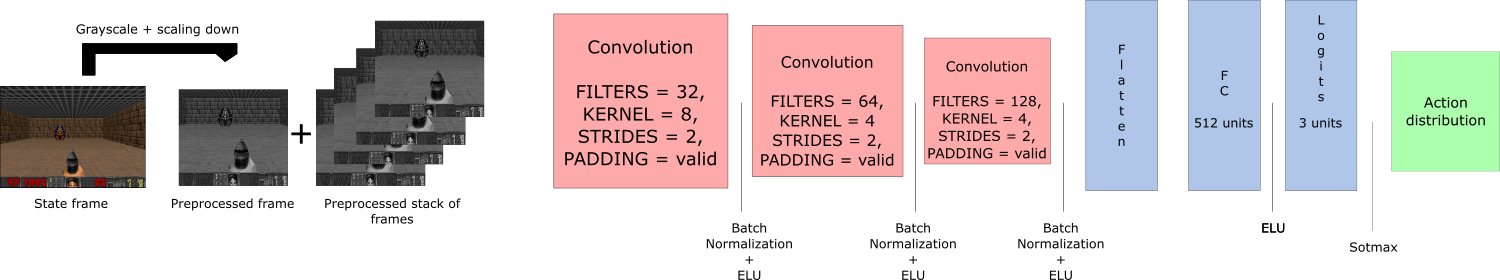

In [0]:
class PGNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='PGNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                # We create the placeholders
                # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
                # [None, 84, 84, 4]
                self.inputs_= tf.placeholder(tf.float32, [None, *state_size], name="inputs_")
                self.actions = tf.placeholder(tf.int32, [None, action_size], name="actions")
                self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None, ], name="discounted_episode_rewards_")
            
                
                # Add this placeholder for having this variable in tensorboard
                self.mean_reward_ = tf.placeholder(tf.float32, name="mean_reward")
                
            with tf.name_scope("conv1"):
                """
                First convnet:
                CNN
                BatchNormalization
                ELU
                """
                # Input is 84x84x4
                self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                             filters = 32,
                                             kernel_size = [8,8],
                                             strides = [4,4],
                                             padding = "VALID",
                                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                             name = "conv1")

                self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm1')

                self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
                ## --> [20, 20, 32]
            
            with tf.name_scope("conv2"):
                """
                Second convnet:
                CNN
                BatchNormalization
                ELU
                """
                self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                     filters = 64,
                                     kernel_size = [4,4],
                                     strides = [2,2],
                                     padding = "VALID",
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                     name = "conv2")

                self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm2')

                self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
                ## --> [9, 9, 64]
            
            with tf.name_scope("conv3"):
                """
                Third convnet:
                CNN
                BatchNormalization
                ELU
                """
                self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                     filters = 128,
                                     kernel_size = [4,4],
                                     strides = [2,2],
                                     padding = "VALID",
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                     name = "conv3")

                self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm3')

                self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
                ## --> [3, 3, 128]
            
            with tf.name_scope("flatten"):
                self.flatten = tf.layers.flatten(self.conv3_out)
                ## --> [1152]
            
            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.flatten,
                                      units = 512,
                                      activation = tf.nn.elu,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                    name="fc1")
            
            with tf.name_scope("logits"):
                self.logits = tf.layers.dense(inputs = self.fc, 
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              units = 3, 
                                            activation=None)
            
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)
                

            with tf.name_scope("loss"):
                # tf.nn.softmax_cross_entropy_with_logits computes the cross entropy of the result after applying the softmax function
                # If you have single-class labels, where an object can only belong to one class, you might now consider using 
                # tf.nn.sparse_softmax_cross_entropy_with_logits so that you don't have to convert your labels to a dense one-hot array. 
                self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions)
                self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episode_rewards_) 
        
    
            with tf.name_scope("train"):
                self.train_opt = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [0]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the PGNetwork
PGNetwork = PGNetwork(state_size, action_size, learning_rate)

# Initialize Session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### 6. Setup Tensorboard 📊

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# Setup tensorboard writer
writer = tf.summary.FileWriter('/tensorboard/pg/1')

# loses
tf.summary.scalar('loss', PGNetwork.loss)

# reward mean
tf.summary.scalar('reward_mean', PGNetwork.mean_reward_)

write_op = tf.summary.merge_all()

### 7. Train our Agent 🏃‍♂️ 

In [0]:
def make_batch(batch_size, stacked_frames):
    # Initialize lists: states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards
    states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards = [], [], [], [], []
    
    # Reward of batch is also a trick to keep track of how many timestep we made.
    # We use to to verify at the end of each episode if > batch_size or not.
    
    # Keep track of how many episodes in our batch (useful when we'll need to calculate the average reward per episode)
    episode_num  = 1
    
    # Launch a new episode
    game.new_episode()
        
    # Get a new state
    state = game.get_state().screen_buffer
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    while True:
        # Run State Through Policy & Calculate Action
        action_probability_distribution = sess.run(PGNetwork.action_distribution, 
                                                   feed_dict={PGNetwork.inputs_: state.reshape(1, *state_size)})
        
        # REMEMBER THAT WE ARE IN A STOCHASTIC POLICY SO WE DON'T ALWAYS TAKE THE ACTION WITH THE HIGHEST PROBABILITY
        # (For instance if the action with the best probability for state S is a1 with 70% chances, there is
        #30% chance that we take action a2)
        action = np.random.choice(range(action_probability_distribution.shape[1]), 
                                  p=action_probability_distribution.ravel())  # select action w.r.t the actions prob
        action = possible_actions[action]

        # Perform action
        reward = game.make_action(action)
        done = game.is_episode_finished()

        # Store results
        states.append(state)
        actions.append(action)
        rewards_of_episode.append(reward)
        
        if done:
            # The episode ends so no next state
            next_state = np.zeros((100, 160), dtype=np.int)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            
            # Append the rewards_of_batch to reward_of_episode
            rewards_of_batch.append(rewards_of_episode)
            
            # Calculate gamma Gt
            discounted_rewards.append(discount_and_normalize_rewards(rewards_of_episode))
           
            # If the number of rewards_of_batch > batch_size stop the minibatch creation
            # (Because we have sufficient number of episode mb)
            # Remember that we put this condition here, because we want entire episode (Monte Carlo)
            # so we can't check that condition for each step but only if an episode is finished
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            # Reset the transition stores
            rewards_of_episode = []
            
            # Add episode
            episode_num += 1
            
            # Start a new episode
            game.new_episode()

            # First we need a state
            state = game.get_state().screen_buffer

            # Stack the frames
            state, stacked_frames = stack_frames(stacked_frames, state, True)
         
        else:
            # If not done, the next_state become the current state
            next_state = game.get_state().screen_buffer
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
                         
    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num

In [0]:
# Keep track of all rewards total for each batch
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
epoch = 1
average_reward = []

# Saver
saver = tf.train.Saver()

if training:
    # Load the model
    #saver.restore(sess, "./models/model.ckpt")

    while epoch < num_epochs + 1:
        # Gather training data
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size, stacked_frames)

        ### These part is used for analytics
        # Calculate the total reward ot the batch
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        allRewards.append(total_reward_of_that_batch)

        # Calculate the mean reward of the batch
        # Total rewards of batch / nb episodes in that batch
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)

        # Calculate the average reward of all training
        # mean_reward_of_that_batch / epoch
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)

        # Calculate maximum reward recorded 
        maximumRewardRecorded = np.amax(allRewards)

        print("==========================================")
        print("Epoch: ", epoch, "/", num_epochs)
        print("-----------")
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward: {}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        # Feedforward, gradient and backpropagation
        loss_, _ = sess.run([PGNetwork.loss, PGNetwork.train_opt], feed_dict={PGNetwork.inputs_: states_mb.reshape((len(states_mb), 100,160,4)),
                                                            PGNetwork.actions: actions_mb,
                                                                     PGNetwork.discounted_episode_rewards_: discounted_rewards_mb 
                                                                    })

        print("Training Loss: {}".format(loss_))

        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={PGNetwork.inputs_: states_mb.reshape((len(states_mb), 100,160,4)),
                                                            PGNetwork.actions: actions_mb,
                                                                     PGNetwork.discounted_episode_rewards_: discounted_rewards_mb,
                                                                    PGNetwork.mean_reward_: mean_reward_of_that_batch
                                                                    })

        #summary = sess.run(write_op, feed_dict={x: s_.reshape(len(s_),84,84,1), y:a_, d_r: d_r_, r: r_, n: n_})
        writer.add_summary(summary, epoch)
        writer.flush()

        # Save Model
        if epoch % 10 == 0:
            saver.save(sess, "./models/model.ckpt")
            print("Model saved")
        epoch += 1

Epoch:  1 / 1000
-----------
Number of training episodes: 3
Total reward: 3.0
Mean Reward of that batch 1.0
Average Reward of all training: 1.0
Max reward for a batch so far: 3.0
Training Loss: 0.009648592211306095
Epoch:  2 / 1000
-----------
Number of training episodes: 3
Total reward: 3.0
Mean Reward of that batch 1.0
Average Reward of all training: 1.0
Max reward for a batch so far: 3.0
Training Loss: -0.005959826521575451
Epoch:  3 / 1000
-----------
Number of training episodes: 4
Total reward: 0.0
Mean Reward of that batch 0.0
Average Reward of all training: 0.6666666666666666
Max reward for a batch so far: 3.0
Training Loss: -0.018194513395428658
Epoch:  4 / 1000
-----------
Number of training episodes: 4
Total reward: -2.0
Mean Reward of that batch -0.5
Average Reward of all training: 0.375
Max reward for a batch so far: 3.0
Training Loss: 0.009513749741017818
Epoch:  5 / 1000
-----------
Number of training episodes: 3
Total reward: 2.0
Mean Reward of that batch 0.6666666666666

### 9. Agent play

Now that we trained our agent, we can test i



In [0]:
# Saver
saver = tf.train.Saver()

with tf.Session() as sess:
    game = DoomGame()

    # Load the correct configuration 
    game.load_config("defend_the_center.cfg")
    
    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("defend_the_center.wad")
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    game.set_window_visible(False)
    game.init()
    
    for i in range(10):
        
        # Launch a new episode
        game.new_episode()

        # Get a new state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)

        while not game.is_episode_finished():
        
            # Run State Through Policy & Calculate Action
            action_probability_distribution = sess.run(PGNetwork.action_distribution, 
                                                       feed_dict={PGNetwork.inputs_: state.reshape(1, *state_size)})

            # REMEMBER THAT WE ARE IN A STOCHASTIC POLICY SO WE DON'T ALWAYS TAKE THE ACTION WITH THE HIGHEST PROBABILITY
            # (For instance if the action with the best probability for state S is a1 with 70% chances, there is
            #30% chance that we take action a2)
            action = np.random.choice(range(action_probability_distribution.shape[1]), 
                                      p=action_probability_distribution.ravel())  # select action w.r.t the actions prob
            action = possible_actions[action]

            # Perform action
            reward = game.make_action(action)
            done = game.is_episode_finished()
            
            if done:
                break
            else:
                # If not done, the next_state become the current state
                next_state = game.get_state().screen_buffer
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state
        

        print("Score for episode ", i, " :", game.get_total_reward())
    game.close()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt
Score for episode  0  : 3.0
Score for episode  1  : 1.0
Score for episode  2  : 5.0
Score for episode  3  : 1.0
Score for episode  4  : 3.0
Score for episode  5  : 4.0
Score for episode  6  : 6.0
Score for episode  7  : 9.0
Score for episode  8  : 7.0
Score for episode  9  : 3.0
